## Python Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os
from tqdm import tqdm 

from module.smatrix import Multilayer
from module.utility import constant_index, make_layer, load_data

## Load Refractive index

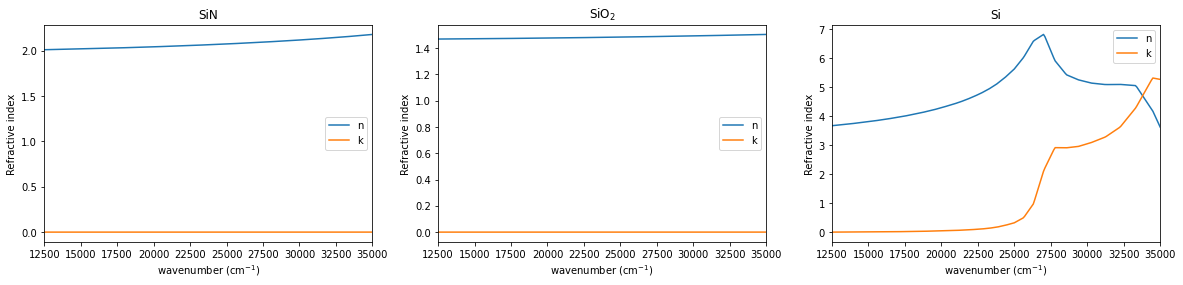

In [2]:
# Wavenumber
wavenumbers = np.linspace(12500, 35000, 226)

# Air
nk_air = constant_index(1, wavenumbers)

# a-Si
sin_n = load_data('refractive_index/sin_n.csv', wavenumbers)
sin_k = load_data('refractive_index/sin_k.csv', wavenumbers)
nk_sin = sin_n + 1j * sin_k

# SiO2
sio2_n = load_data('refractive_index/sio2_n.csv', wavenumbers)
sio2_k = load_data('refractive_index/sio2_k.csv', wavenumbers)
nk_sio2 = sio2_n + 1j * sio2_k

# Si
si_n = load_data('refractive_index/si_n.csv', wavenumbers)
si_k = load_data('refractive_index/si_k.csv', wavenumbers)
nk_si = si_n + 1j * si_k

# Plot
plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.title('SiN')
plt.plot(wavenumbers, sin_n, label='n')
plt.plot(wavenumbers, sin_k, label='k')
plt.legend()
plt.xlim(wavenumbers.min(), wavenumbers.max())
plt.ylabel('Refractive index')
plt.xlabel('wavenumber (cm$^{-1}$)')

plt.subplot(132)
plt.title('SiO$_{2}$')
plt.plot(wavenumbers, sio2_n, label='n')
plt.plot(wavenumbers, sio2_k, label='k')
plt.legend()
plt.xlim(wavenumbers.min(), wavenumbers.max())
plt.ylabel('Refractive index')
plt.xlabel('wavenumber (cm$^{-1}$)')

plt.subplot(133)
plt.title('Si')
plt.plot(wavenumbers, si_n, label='n')
plt.plot(wavenumbers, si_k, label='k')
plt.legend()
plt.xlim(wavenumbers.min(), wavenumbers.max())
plt.ylabel('Refractive index')
plt.xlabel('wavenumber (cm$^{-1}$)')
plt.show()


## Data Set

In [3]:
def df_one_row( d_sio2_1, d_sio2_2, noise_level=0):    
    # Structure
    layer_air = make_layer(nk_air)
    #layer_sin_1 = make_layer(nk_sin, thickness=d_sin_1*1e-7, coherence=True) #thickness unit_nanometer scale
    #layer_sin_2 = make_layer(nk_sin, thickness=d_sin_2*1e-7, coherence=True)
    layer_sio2_1 = make_layer(nk_sio2, thickness=d_sio2_1*1e-7, coherence=True)
    layer_sio2_2 = make_layer(nk_sio2, thickness=d_sio2_2*1e-7, coherence=True)
    layer_si = make_layer(nk_si, thickness=0.05, coherence=False)#thickness unit_centimeter scale
    structure = [
        layer_air,  
        layer_sio2_1,
        layer_si,
        layer_sio2_2,
        layer_air]
    
    #R = Multilayer(structure, 0, 's', wavenumbers).R() #Multilayer에서 return 값 R을 받아옴. class 구조는 str, 입사각, 편광, wavenumber를 받음.
    R=Multilayer(structure, 0, 's', wavenumbers).R()
    noise = (2*np.random.rand(len(wavenumbers))-1)/100
    R += noise * noise_level
    R *= 1+(2*np.random.rand()-1)/100
    R = R.reshape(1, -1)
    
    label = np.array([ d_sio2_1,  d_sio2_2]).reshape(1, -1)
    df_1 = pd.DataFrame(data=label, columns=['layer_1', 'layer_2'])
    df_2 = pd.DataFrame(data=R)
    df = pd.concat([df_1, df_2], axis=1)
    return df

def linspace(a, b, step):
    out = []
    i = a
    while i <= b:
        out.append(i)
        i += step
    return out

## Train Data

In [4]:
random.seed(0)
np.random.seed(0)
df_list = []
d_i = 0
d_f = 300
step = 10
end = np.power(((d_f - d_i)/step + 1), 2)
start_time = time.time()
i = 1

for d_sio2_1 in linspace(d_i, d_f, step):
    for d_sio2_2 in linspace(d_i, d_f, step):
        df = df_one_row( d_sio2_1, d_sio2_2, noise_level=1.5)
        df_list.append(df)
        i += 1
        if i%100 == 0:
            process_time = time.time() - start_time
            end_time = end * process_time / i
            print('%7i/%i %8.1f s / %5.1f s'%(i, end, process_time, end_time), end='\r')
data = pd.concat(df_list).reset_index(drop=True)
#data.head()
data.tail()

,layer_1,layer_2,0,1,2,3,4,5,6,7,...,216,217,218,219,220,221,222,223,224,225
956,300,260,0.318455,0.304694,0.308860,0.309298,0.301995,0.294464,0.275851,0.280679,...,0.661390,0.659245,0.664531,0.664742,0.667015,0.649453,0.650829,0.643863,0.657648,0.640344
957,300,270,0.295825,0.314078,0.286163,0.296527,0.294304,0.280291,0.270550,0.272087,...,0.642154,0.667741,0.652966,0.665720,0.671367,0.651675,0.652147,0.645166,0.635411,0.634454
958,300,280,0.312850,0.295081,0.292961,0.304805,0.285292,0.296919,0.289884,0.284754,...,0.648812,0.647973,0.661670,0.651344,0.653454,0.638613,0.648054,0.640075,0.647773,0.631762
959,300,290,0.293051,0.295539,0.306962,0.290658,0.296403,0.275395,0.291454,0.266641,...,0.650728,0.650518,0.639725,0.639812,0.640498,0.636107,0.657069,0.641349,0.628661,0.645504
960,300,300,0.293353,0.309285,0.306267,0.306773,0.287152,0.276439,0.277743,0.287416,...,0.645377,0.659458,0.642642,0.672587,0.655108,0.662744,0.647187,0.639554,0.635857,0.650332


# Columns filtering

In [ ]:
data.to_csv('data1.csv', index=False)